In [ ]:
import numpy as np
import pandas as pd
# import spektral

In [ ]:
# !pip install "colorama>=0.3.8"
# !pip uninstall h2o
# !pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [ ]:
np.random.seed(42)

In [ ]:
import os 

path = '/content/drive/My Drive/IIITH/GCN_KEGG/GCN_Dataset/CSV'
os.listdir(path)

['Clinical_KICH_81_tumors.csv',
 'Clinical_KIRP_290_tumors.csv',
 'Clinical_KIRC_518_tumors.csv',
 'KICH_81_tumors_log_transformed.csv',
 'KIRP_290_tumors_log_transformed.csv',
 'KIRC_518_tumors_log_transformed.csv',
 '.DS_Store']

In [ ]:
def load_dataset(path, filename, transpose=True):
    '''
        Loads the dataset and converts into its transpose with appropriate columns
    '''
    df = pd.read_csv(os.path.join(path, filename))
    df.rename(columns={"Unnamed: 0": "pid"}, inplace=True)
    if transpose:
        df = df.astype({"pid": str})
        df = df.T
        new_header = df.iloc[0] 
        df = df[1:]
        df.columns = new_header
    return df

In [ ]:
df_kirc = load_dataset(path,'KIRC_518_tumors_log_transformed.csv',transpose=True)
patient_data_kirc = load_dataset(path,'Clinical_KIRC_518_tumors.csv',transpose=False)
pid_kirc_drop1 = patient_data_kirc[patient_data_kirc['ajcc_pathologic_tumor_stage']=='[Not Available]'].pid
pid_kirc_drop2 = patient_data_kirc[patient_data_kirc['ajcc_pathologic_tumor_stage']=='[Discrepancy]'].pid
patient_data_kirc.drop(patient_data_kirc[patient_data_kirc['ajcc_pathologic_tumor_stage']=='[Not Available]'].index, inplace=True )
patient_data_kirc.drop(patient_data_kirc[patient_data_kirc['ajcc_pathologic_tumor_stage']=='[Discrepancy]'].index, inplace=True )
df_kirc.drop(pid_kirc_drop1,inplace=True)
df_kirc.drop(pid_kirc_drop2,inplace=True)

y_kirc=[]
for pid in df_kirc.index:
    stage=patient_data_kirc[patient_data_kirc['pid']==pid]['ajcc_pathologic_tumor_stage']
    stage = stage.values[0]
    if stage=='Stage I':
        y_kirc.append(0)
    elif stage=='Stage II':
        y_kirc.append(0)
    elif stage=='Stage III':
        y_kirc.append(1)
    elif stage=='Stage IV':
        y_kirc.append(1)

data = df_kirc
y = y_kirc

(array([314.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 201.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

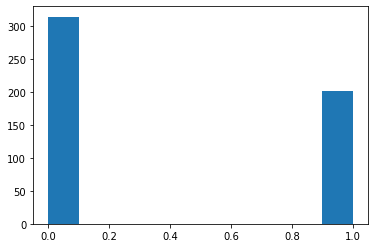

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y)

In [ ]:
def get_features_matrix(pathway):

  genes_used = set()

  for i in range(len(pathway)):
      genes_used.add(pathway.iloc[i]['from'][4:])
      genes_used.add(pathway.iloc[i]['to'][4:])
  
#   genes_used = ['286','55252','1436','11143','6935','286','8289','55252',
# '8314',
# '672',
# '675',
# '1436',
# '2068',
# '2071',
# '2072',
# '100533467',
# '2189',
# '11143',
# '4233',
# '5546',
# '54894',
# '7030',
# '6935']

  # print(len(genes_used))

  to_remove = []

  for gene in genes_used:
      if gene not in data.columns:
          to_remove.append(gene)

  for gene in to_remove:
    genes_used.remove(gene)

  genes_used = list(genes_used)
  genes_used.sort()

  # print(len(genes_used))

  return genes_used

In [ ]:
kegg_pathways_path = '/content/drive/My Drive/IIITH/GCN_KEGG/KEGG_csv'

In [ ]:
def store_pca_tsne_plots(X, y, fname):
  path_to_save = '/content/drive/My Drive/IIITH/GCN_KEGG/KIRC_Stage_TSNE_PCA_Plots'
  from sklearn.manifold import TSNE
  tsne = TSNE(n_components=2, random_state=0, perplexity=35)
  X_2d_tsne = tsne.fit_transform(X)
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6, 5))
  plt.scatter(X_2d_tsne[:, 0], X_2d_tsne[:, 1], c=y)
  plt.savefig(os.path.join(path_to_save,'tsne',fname+'_tsne.png'))
  plt.close()
  from sklearn.decomposition import PCA
  pca = PCA(n_components=2, whiten=True)
  X_2d_pca = pca.fit_transform(X) 
  plt.scatter(X_2d_pca[:, 0], X_2d_pca[:, 1], c=y) 
  plt.savefig(os.path.join(path_to_save,'pca',fname+'_pca.png'))
  plt.close()
  from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
  lda = LinearDiscriminantAnalysis(n_components=2)
  X_r2 = lda.fit(X, y).transform(X)
  plt.figure(figsize=(6, 5))
  plt.scatter(X_r2, y, c=y)
  plt.savefig(os.path.join(path_to_save,'lda',fname+'_lda.png'))
  plt.close()

In [ ]:
y = np.asarray(y)

In [ ]:
from sklearn.model_selection import train_test_split
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
new_X_matrix_train = []
new_X_matrix_test = []
lda_scores = []

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Classifiers
from sklearn.svm import NuSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
features_used = []

#OLD

In [ ]:
from sklearn.model_selection import train_test_split
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
lda_scores= []

from tqdm import tqdm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import TruncatedSVD

files_to_use = os.listdir(kegg_pathways_path)
files_to_use.sort()

for file in tqdm(files_to_use):
	if 'hsa' not in file:
		continue
	pathway = pd.read_csv(os.path.join(kegg_pathways_path,file))
	pathway.rename(columns={"Unnamed: 0": "idx"}, inplace=True)
	X_train = data_train[get_features_matrix(pathway)]
	X_test = data_test[get_features_matrix(pathway)]
	if X_test.shape[1]==0:
		continue



	X_train = X_train.to_numpy()
	X_test = X_test.to_numpy()
	X = np.concatenate([X_train, X_test])
	sc = RobustScaler()
	# X = sc.fit_transform(X)
	X_train = sc.fit_transform(X_train)
	X_test = sc.transform(X_test)
	# X_train = X[0:len(y_train)]
	# X_test = X[len(y_train):]


	# Initializing Support Vector classifier
	clf1 = ExtraTreesClassifier(max_depth=15, random_state=0, n_estimators=1500)
	clf2 = RandomForestClassifier(n_estimators = 1500, criterion = "gini", max_depth = 15,
																	max_features = "auto", min_samples_leaf = 0.005,
																	min_samples_split = 0.005, n_jobs = -1, random_state = 0) 
	clf3 = GaussianNB()
	clf4 = SVC(random_state=0, class_weight='balanced', kernel='rbf', probability=True)
	clf5 = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=100, alpha=0.01,
                    activation = 'relu',solver='sgd', verbose=0,  random_state=0,tol=0.0000001)

	eclf3 = VotingClassifier(estimators=[
        ('lr', clf1), 
        ('rf', clf2), 
        ('nb', clf3), 
        ('svm', clf4), 
        ('nn', clf5)],
        voting='soft', weights=[1,2,4,2,3],
        flatten_transform=True)
	eclf3 = eclf3.fit(X_train, y_train)


	score = eclf3.score(X_test, y_test)
 
	lda_scores.append(score)
	print(file, score)
	if score>0.78:
		features_used.append(file)
		

		# gcn_pathway_output = eclf3.predict_proba(X)
		# filename_output_csv = os.path.join("/content/drive/My Drive/IIITH/GCN_KEGG/KIRC_Stage_TSNE_PCA_Plots/GCN_Pathway_output_scores",file)
		# np.savetxt(filename_output_csv,gcn_pathway_output)    
	

	



  0%|          | 0/123 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
  1%|          | 1/123 [00:08<17:49,  8.76s/it]

hsa00010 .csv 0.6893203883495146


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
  2%|▏         | 2/123 [00:15<16:40,  8.27s/it]

hsa00051 .csv 0.7087378640776699


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
  2%|▏         | 3/123 [00:22<15:44,  7.87s/it]

hsa00250 .csv 0.7087378640776699


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
  3%|▎         | 4/123 [00:29<15:09,  7.64s/it]

hsa00260 .csv 0.6213592233009708


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
  4%|▍         | 5/123 [00:37<14:48,  7.53s/it]

hsa00280 .csv 0.6893203883495146


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
  5%|▍         | 6/123 [00:44<14:46,  7.58s/it]

hsa00830 .csv 0.6213592233009708


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
  6%|▌         | 7/123 [00:52<14:26,  7.47s/it]

hsa00860 .csv 0.6893203883495146


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
  7%|▋         | 8/123 [01:00<14:34,  7.60s/it]

hsa01522 .csv 0.7475728155339806


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
  7%|▋         | 9/123 [01:07<14:24,  7.58s/it]

hsa03320 .csv 0.6601941747572816


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
  8%|▊         | 10/123 [01:18<16:20,  8.68s/it]

hsa04010 .csv 0.7572815533980582


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
  9%|▉         | 11/123 [01:26<15:43,  8.42s/it]

hsa04012 .csv 0.7184466019417476


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 10%|▉         | 12/123 [01:36<16:23,  8.86s/it]

hsa04014 .csv 0.7475728155339806


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 11%|█         | 13/123 [01:46<16:43,  9.12s/it]

hsa04015 .csv 0.8058252427184466


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 11%|█▏        | 14/123 [01:54<16:22,  9.01s/it]

hsa04020 .csv 0.7087378640776699


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 12%|█▏        | 15/123 [02:03<16:01,  8.90s/it]

hsa04022 .csv 0.7572815533980582


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 13%|█▎        | 16/123 [02:13<16:15,  9.12s/it]

hsa04024 .csv 0.7281553398058253


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 14%|█▍        | 17/123 [02:23<16:46,  9.49s/it]

hsa04062 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 15%|█▍        | 18/123 [02:31<15:43,  8.98s/it]

hsa04064 .csv 0.6990291262135923


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 15%|█▌        | 19/123 [02:39<15:05,  8.70s/it]

hsa04066 .csv 0.7572815533980582


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 16%|█▋        | 20/123 [02:48<14:52,  8.66s/it]

hsa04068 .csv 0.7766990291262136


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 17%|█▋        | 21/123 [02:55<14:18,  8.42s/it]

hsa04071 .csv 0.7475728155339806


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 18%|█▊        | 22/123 [03:04<14:04,  8.36s/it]

hsa04072 .csv 0.7281553398058253


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 19%|█▊        | 23/123 [03:12<14:10,  8.50s/it]

hsa04110 .csv 0.7184466019417476


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 20%|█▉        | 24/123 [03:20<13:32,  8.21s/it]

hsa04115 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 20%|██        | 25/123 [03:27<13:02,  7.98s/it]

hsa04137 .csv 0.7184466019417476


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 21%|██        | 26/123 [03:36<13:11,  8.16s/it]

hsa04140 .csv 0.7475728155339806


 22%|██▏       | 27/123 [03:36<09:17,  5.80s/it]/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 23%|██▎       | 28/123 [03:44<10:05,  6.38s/it]

hsa04144 .csv 0.7475728155339806


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 24%|██▎       | 29/123 [03:51<10:08,  6.47s/it]

hsa04145 .csv 0.7184466019417476


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 24%|██▍       | 30/123 [04:00<11:08,  7.18s/it]

hsa04150 .csv 0.7572815533980582


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 25%|██▌       | 31/123 [04:12<13:21,  8.71s/it]

hsa04151 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 26%|██▌       | 32/123 [04:20<12:48,  8.45s/it]

hsa04152 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 27%|██▋       | 33/123 [04:28<12:38,  8.43s/it]

hsa04210 .csv 0.7475728155339806


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 28%|██▊       | 34/123 [04:36<12:05,  8.15s/it]

hsa04211 .csv 0.7475728155339806


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 28%|██▊       | 35/123 [04:42<11:01,  7.51s/it]

hsa04216 .csv 0.6601941747572816


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 29%|██▉       | 36/123 [04:50<11:15,  7.76s/it]

hsa04217 .csv 0.7475728155339806


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 30%|███       | 37/123 [04:59<11:32,  8.05s/it]

hsa04218 .csv 0.7475728155339806


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 31%|███       | 38/123 [05:08<11:57,  8.44s/it]

hsa04261 .csv 0.7184466019417476


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 32%|███▏      | 39/123 [05:16<11:43,  8.37s/it]

hsa04270 .csv 0.7572815533980582


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 33%|███▎      | 40/123 [05:25<11:51,  8.58s/it]

hsa04310 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 33%|███▎      | 41/123 [05:32<11:07,  8.14s/it]

hsa04340 .csv 0.6893203883495146


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 34%|███▍      | 42/123 [05:40<10:55,  8.09s/it]

hsa04350 .csv 0.7475728155339806


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 35%|███▍      | 43/123 [05:49<11:05,  8.31s/it]

hsa04360 .csv 0.7087378640776699


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 36%|███▌      | 44/123 [05:56<10:32,  8.00s/it]

hsa04370 .csv 0.7184466019417476


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 37%|███▋      | 45/123 [06:05<10:38,  8.19s/it]

hsa04371 .csv 0.7087378640776699


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 37%|███▋      | 46/123 [06:13<10:33,  8.23s/it]

hsa04380 .csv 0.6796116504854369


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 38%|███▊      | 47/123 [06:22<10:39,  8.41s/it]

hsa04390 .csv 0.7184466019417476


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 39%|███▉      | 48/123 [06:32<11:11,  8.96s/it]

hsa04510 .csv 0.6990291262135923


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 40%|███▉      | 49/123 [06:40<10:27,  8.48s/it]

hsa04520 .csv 0.7475728155339806


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 41%|████      | 50/123 [06:49<10:32,  8.66s/it]

hsa04530 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 41%|████▏     | 51/123 [06:57<10:14,  8.53s/it]

hsa04550 .csv 0.7087378640776699


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 42%|████▏     | 52/123 [07:04<09:32,  8.07s/it]

hsa04610 .csv 0.6893203883495146


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 43%|████▎     | 53/123 [07:12<09:27,  8.10s/it]

hsa04611 .csv 0.7475728155339806


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 44%|████▍     | 54/123 [07:18<08:24,  7.32s/it]

hsa04614 .csv 0.6310679611650486


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 45%|████▍     | 55/123 [07:26<08:29,  7.50s/it]

hsa04620 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 46%|████▌     | 56/123 [07:34<08:42,  7.80s/it]

hsa04621 .csv 0.7087378640776699


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 46%|████▋     | 57/123 [07:41<08:21,  7.60s/it]

hsa04622 .csv 0.7281553398058253


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 47%|████▋     | 58/123 [07:48<07:54,  7.30s/it]

hsa04623 .csv 0.7281553398058253


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 48%|████▊     | 59/123 [07:56<08:00,  7.51s/it]

hsa04625 .csv 0.7281553398058253


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 49%|████▉     | 60/123 [08:06<08:44,  8.32s/it]

hsa04630 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 50%|████▉     | 61/123 [08:14<08:33,  8.28s/it]

hsa04650 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 50%|█████     | 62/123 [08:20<07:45,  7.63s/it]

hsa04657 .csv 0.6990291262135923


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 51%|█████     | 63/123 [08:28<07:40,  7.67s/it]

hsa04658 .csv 0.7475728155339806


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 52%|█████▏    | 64/123 [08:36<07:35,  7.72s/it]

hsa04659 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 53%|█████▎    | 65/123 [08:44<07:35,  7.86s/it]

hsa04660 .csv 0.7669902912621359


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 54%|█████▎    | 66/123 [08:52<07:20,  7.73s/it]

hsa04662 .csv 0.7281553398058253


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 54%|█████▍    | 67/123 [08:59<07:04,  7.58s/it]

hsa04664 .csv 0.7669902912621359


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 55%|█████▌    | 68/123 [09:07<06:58,  7.61s/it]

hsa04666 .csv 0.6990291262135923


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 56%|█████▌    | 69/123 [09:14<06:48,  7.57s/it]

hsa04668 .csv 0.6990291262135923


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 57%|█████▋    | 70/123 [09:22<06:51,  7.77s/it]

hsa04670 .csv 0.7087378640776699


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 58%|█████▊    | 71/123 [09:30<06:47,  7.84s/it]

hsa04713 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 59%|█████▊    | 72/123 [09:38<06:36,  7.77s/it]

hsa04714 .csv 0.7572815533980582


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 59%|█████▉    | 73/123 [09:45<06:24,  7.69s/it]

hsa04720 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 60%|██████    | 74/123 [09:54<06:23,  7.83s/it]

hsa04722 .csv 0.7475728155339806


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 61%|██████    | 75/123 [10:02<06:18,  7.89s/it]

hsa04723 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 62%|██████▏   | 76/123 [10:09<06:10,  7.87s/it]

hsa04724 .csv 0.7475728155339806


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 63%|██████▎   | 77/123 [10:17<06:02,  7.87s/it]

hsa04725 .csv 0.7087378640776699


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 63%|██████▎   | 78/123 [10:25<05:48,  7.75s/it]

hsa04726 .csv 0.6893203883495146


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 64%|██████▍   | 79/123 [10:33<05:52,  8.01s/it]

hsa04728 .csv 0.7475728155339806


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 65%|██████▌   | 80/123 [10:41<05:33,  7.75s/it]

hsa04730 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 66%|██████▌   | 81/123 [10:48<05:23,  7.71s/it]

hsa04750 .csv 0.7087378640776699


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 67%|██████▋   | 82/123 [10:58<05:39,  8.28s/it]

hsa04810 .csv 0.7281553398058253


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 67%|██████▋   | 83/123 [11:06<05:35,  8.38s/it]

hsa04910 .csv 0.6893203883495146


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 68%|██████▊   | 84/123 [11:13<05:09,  7.93s/it]

hsa04911 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 69%|██████▉   | 85/123 [11:21<04:58,  7.87s/it]

hsa04912 .csv 0.7281553398058253


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 70%|██████▉   | 86/123 [11:28<04:37,  7.51s/it]

hsa04913 .csv 0.7184466019417476


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 71%|███████   | 87/123 [11:36<04:38,  7.74s/it]

hsa04915 .csv 0.7087378640776699


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 72%|███████▏  | 88/123 [11:44<04:35,  7.89s/it]

hsa04916 .csv 0.6893203883495146


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 72%|███████▏  | 89/123 [11:51<04:22,  7.73s/it]

hsa04917 .csv 0.6893203883495146


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 73%|███████▎  | 90/123 [11:58<04:05,  7.44s/it]

hsa04918 .csv 0.6990291262135923


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 74%|███████▍  | 91/123 [12:06<04:05,  7.66s/it]

hsa04919 .csv 0.7281553398058253


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 75%|███████▍  | 92/123 [12:14<03:53,  7.53s/it]

hsa04920 .csv 0.7281553398058253


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 76%|███████▌  | 93/123 [12:22<03:54,  7.82s/it]

hsa04921 .csv 0.7669902912621359


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 76%|███████▋  | 94/123 [12:30<03:47,  7.85s/it]

hsa04922 .csv 0.7281553398058253


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 77%|███████▋  | 95/123 [12:37<03:32,  7.58s/it]

hsa04923 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 78%|███████▊  | 96/123 [12:44<03:18,  7.34s/it]

hsa04924 .csv 0.7087378640776699


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 79%|███████▉  | 97/123 [12:51<03:12,  7.42s/it]

hsa04925 .csv 0.7087378640776699


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 80%|███████▉  | 98/123 [13:00<03:12,  7.70s/it]

hsa04926 .csv 0.7184466019417476


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 80%|████████  | 99/123 [13:07<02:58,  7.43s/it]

hsa04927 .csv 0.7475728155339806


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 81%|████████▏ | 100/123 [13:14<02:52,  7.51s/it]

hsa04928 .csv 0.7766990291262136


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 82%|████████▏ | 101/123 [13:21<02:42,  7.41s/it]

hsa04929 .csv 0.7572815533980582


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 83%|████████▎ | 102/123 [13:30<02:40,  7.63s/it]

hsa04935 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 84%|████████▎ | 103/123 [13:36<02:25,  7.25s/it]

hsa04960 .csv 0.7087378640776699


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 85%|████████▍ | 104/123 [13:43<02:15,  7.13s/it]

hsa04961 .csv 0.7087378640776699


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 85%|████████▌ | 105/123 [13:49<02:04,  6.92s/it]

hsa04962 .csv 0.7378640776699029


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 86%|████████▌ | 106/123 [13:56<01:58,  6.95s/it]

hsa04970 .csv 0.7864077669902912


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 87%|████████▋ | 107/123 [14:03<01:50,  6.90s/it]

hsa04971 .csv 0.6990291262135923


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 88%|████████▊ | 108/123 [14:10<01:41,  6.77s/it]

hsa04972 .csv 0.7961165048543689


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 89%|████████▊ | 109/123 [14:15<01:31,  6.53s/it]

hsa04973 .csv 0.6407766990291263


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 89%|████████▉ | 110/123 [14:22<01:24,  6.49s/it]

hsa04976 .csv 0.6504854368932039


 90%|█████████ | 111/123 [14:22<00:55,  4.64s/it]/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 91%|█████████ | 112/123 [14:28<00:55,  5.04s/it]

hsa04978 .csv 0.6310679611650486


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 92%|█████████▏| 113/123 [14:35<00:54,  5.49s/it]

hsa04979 .csv 0.6990291262135923


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 93%|█████████▎| 114/123 [14:47<01:08,  7.65s/it]

hsa05200 .csv 0.7669902912621359


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 93%|█████████▎| 115/123 [14:54<00:58,  7.26s/it]

hsa05202 .csv 0.7184466019417476


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 94%|█████████▍| 116/123 [15:01<00:51,  7.29s/it]

hsa05204 .csv 0.6990291262135923


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 95%|█████████▌| 117/123 [15:11<00:47,  7.97s/it]

hsa05205 .csv 0.7184466019417476


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 96%|█████████▌| 118/123 [15:18<00:38,  7.68s/it]

hsa05211 .csv 0.7281553398058253


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 97%|█████████▋| 119/123 [15:25<00:30,  7.63s/it]

hsa05230 .csv 0.7572815533980582


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 98%|█████████▊| 120/123 [15:33<00:22,  7.57s/it]

hsa05231 .csv 0.7281553398058253


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
100%|██████████| 123/123 [15:40<00:00,  7.65s/it]

hsa05235 .csv 0.7475728155339806


In [ ]:
# from sklearn import metrics
# y_pred = eclf3.predict(X_test)
# print(metrics.classification_report(y_test, y_pred))

In [ ]:
lda_scores = np.asarray(lda_scores)

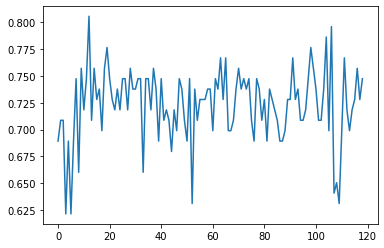

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lda_scores)

In [ ]:
np.mean(lda_scores)

0.7235049359549646

In [ ]:
[i for i in lda_scores if i>0.77]
# lda_scores

[0.8058252427184466,
 0.7766990291262136,
 0.7766990291262136,
 0.7864077669902912,
 0.7961165048543689]

In [ ]:
# y_labels = np.concatenate([y_train, y_test])
# filename_output_csv = os.path.join("/content/drive/My Drive/IIITH/GCN_KEGG/KIRC_Stage_TSNE_PCA_Plots","labels.csv")
# np.savetxt(filename_output_csv,y_labels)

In [ ]:
# new_gene_set = set()

# for gene in features_used[1]:
#   new_gene_set.add(gene)
# for gene in features_used[20]:
#   new_gene_set.add(gene)

In [ ]:
# len(new_gene_set)

In [ ]:
len(y_train)

412

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import StratifiedKFold, KFold
import pickle

for seed in [0]:
  # data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=seed, stratify=y)


  pathway = pd.read_csv(os.path.join(kegg_pathways_path,'hsa04015 .csv'))
  pathway.rename(columns={"Unnamed: 0": "idx"}, inplace=True)
  X_train = data_train[get_features_matrix(pathway)]
  X_test = data_test[get_features_matrix(pathway)]




  X_train = X_train.to_numpy()
  X_test = X_test.to_numpy()
  X = np.concatenate([X_train, X_test])
  sc = RobustScaler()
  # X = sc.fit_transform(X)
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)
  # X_train = X[0:len(y_train)]
  # X_test = X[len(y_train):]
  max_score = -100

  skf = StratifiedKFold(n_splits=10)
  # for train, test in skf.split(X_train, y_train):
  # print(y_train[train].shape)
  # Initializing Support Vector classifier
  clf1 = ExtraTreesClassifier(max_depth=15, random_state=0, n_estimators=1500)
  clf2 = RandomForestClassifier(n_estimators = 1500, criterion = "gini", max_depth = 5,
                                  max_features = "auto", min_samples_leaf = 0.005,
                                  min_samples_split = 0.005, n_jobs = -1, random_state = 0) 
  clf3 = GaussianNB()
  clf4 = SVC(random_state=0, class_weight='balanced', kernel='rbf', probability=True)
  clf5 = MLPClassifier(hidden_layer_sizes=(128,128), max_iter=300, alpha=0.01,
                      activation = 'relu',solver='sgd', verbose=0,  random_state=0,tol=0.000000001)

  eclf3 = VotingClassifier(estimators=[
        # ('lr', clf1), 
        ('rf', clf2), 
        ('nb', clf3), 
        ('svm', clf4), 
        ('nn', clf5)],
        voting='soft', weights=[1,3,1,2],
        flatten_transform=True)

# eclf3 = RandomForestClassifier(n_estimators = 1500, criterion = "gini", max_depth = 5,
#                                 max_features = "auto", min_samples_leaf = 0.005,
#                                 min_samples_split = 0.005, n_jobs = -1, random_state = 0) 

  eclf3 = eclf3.fit(X_train, y_train)
  val_score = metrics.accuracy_score(y_train, eclf3.predict(X_train))
  print("Train acc ", val_score)
  # if val_score > max_score:
  #   max_score = val_score
  #   # print("Saving model...")
  #   pkl_filename = "pickle_model.pkl"
  #   with open(pkl_filename, 'wb') as file:
  #       pickle.dump(eclf3, file)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Train acc  0.7451456310679612


In [ ]:
from sklearn import metrics
# eclf3 = VotingClassifier(estimators=[
#       ('lr', clf1), ('rf', clf2), ('nb', clf3), ('svm', clf4), ('nn', clf5)],
#       voting='soft', weights=[1,1,4,1,4],
#       flatten_transform=True)

# Load from file
# with open(pkl_filename, 'rb') as file:
#     pickle_model = pickle.load(file)
# eclf3 = pickle_model.fit(X_train, y_train)
y_pred = eclf3.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        63
           1       0.83      0.62      0.71        40

    accuracy                           0.81       103
   macro avg       0.81      0.77      0.78       103
weighted avg       0.81      0.81      0.80       103

0.8058252427184466


In [ ]:
y_pred1 = eclf3.predict_proba(X_test)
print(metrics.roc_auc_score(y_test, y_pred1[:,1]))

0.8281746031746032


In [ ]:
corrMatrix[corrMatrix['y_kirc']<-0.29].index.tolist()

['2788_kirc']

In [ ]:
features_to_use = set()
files_to_use = os.listdir(kegg_pathways_path)
files_to_use.sort()

for file in tqdm(files_to_use):
	if 'hsa' not in file:
		continue
	pathway = pd.read_csv(os.path.join(kegg_pathways_path,file))
	pathway.rename(columns={"Unnamed: 0": "idx"}, inplace=True)
	data_subset = data_train[get_features_matrix(pathway)]
	data_subset = data_subset.assign(y=pd.Series(y_train).values)
	data_subset = data_subset.apply(pd.to_numeric) 
	corrMatrix = data_subset.corr()
	features_to_use.update(corrMatrix[corrMatrix['y']<-0.29].index.tolist())
	features_to_use.update(corrMatrix[corrMatrix['y']>0.29].index.tolist())

100%|██████████| 123/123 [00:25<00:00,  4.81it/s]


In [ ]:
features_to_use.remove('y')

In [ ]:
X_train = data_train[list(features_to_use)]
X_test = data_test[list(features_to_use)]




X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X = np.concatenate([X_train, X_test])
sc = RobustScaler()
# X = sc.fit_transform(X)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# X_train = X[0:len(y_train)]
# X_test = X[len(y_train):]


# Initializing Support Vector classifier
clf1 = ExtraTreesClassifier(max_depth=15, random_state=0, n_estimators=1500)
clf2 = RandomForestClassifier(n_estimators = 2500, criterion = "gini", max_depth = 5,
                                max_features = "auto", min_samples_leaf = 0.005,
                                min_samples_split = 0.005, n_jobs = -1, random_state = 0) 
clf3 = GaussianNB()
clf4 = SVC(random_state=0, class_weight='balanced', kernel='rbf', probability=True)
clf5 = MLPClassifier(hidden_layer_sizes=(40), max_iter=30, alpha=0.1,
                    activation = 'relu',solver='sgd', verbose=0,  random_state=0,tol=0.000000001)

# eclf3 = VotingClassifier(estimators=[
#       ('lr', clf1), 
#       ('rf', clf2), 
#       ('nb', clf3), 
#       ('svm', clf4), 
#       ('nn', clf5)],
#       voting='soft', weights=[1,1.5,3,1.5,2],
#       flatten_transform=True)
eclf3 = clf5
eclf3 = eclf3.fit(X_train, y_train)


score = eclf3.score(X_test, y_test)
print(score)

0.7572815533980582


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
features_to_use = set()
data_subset = data_train
data_subset = data_subset.assign(y=pd.Series(y_train).values)
data_subset = data_subset.apply(pd.to_numeric) 
corrMatrix = data_subset.corr()
features_to_use.update(corrMatrix[corrMatrix['y']<-0.3].index.tolist())
features_to_use.update(corrMatrix[corrMatrix['y']>0.3].index.tolist())

KeyboardInterrupt: ignored

In [ ]:
corrMatrix.shape